- (o) target transformation
- (o) group scaling
- interaction term
- feature selection
- outlier detection
- (o) memory reduce
- (o) hour기준 시간대정보: "아침","오후","저녁","밤"
- (o) 기온,강수량,풍속,습도로 파생변수 생성
- (o) 주기성정보: sin_hour, cos_hour
- (x) 전일차이 & rolling mean/std -> test까지 고려해서 넣어야하므로 복잡함
- (o) stacking
- kfold -> timeseries kfold
- (x) lag variable -> 속도만느려지는거같음
- (x) target lag variable -> 성능 매우 안좋아짐
- weiens -> cv추가
- xgb,lgb는 성능이 안좋음 -> 제거
- stacking에서 5개평균으로 넣어보기

# Setting

In [1]:
import sys
sys.path.append('/Volumes/KHJ/Github/hyuckjinkim/lib-python')

In [2]:
from base import gc_collect_all
from data_prepare import (
    get_holiday, reduce_mem_usage, delete_unique_columns,
    TypeController, CategoricalQuantileCalculator,
    GroupScaler, OneHotEncoder, InteractionTerm, TargetTransform,
)

In [3]:
gc_collect_all()

In [4]:
from tqdm import tqdm
tqdm.pandas()

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

import datetime

pd.set_option('mode.chained_assignment',  None)

In [5]:
def global_assignment(dictionary):
    for k,v in dictionary.items():
        exec("globals()['{}']=dictionary['{}']".format(k,k))

In [6]:
def smape(true, pred):
    v = 2 * abs(pred - true) / (abs(pred) + abs(true))
    output = np.mean(v) * 100
    return output

In [7]:
import numpy as np

class TargetTransfom:
    def __init__(self,transform='identity'):
        assert transform in ['identity','log','sqrt'], \
            print("transform must be one of ['identity','log','sqrt']")
        self.transform = transform
        
    def fit(self,target,verbose=True):
        x = np.array(target)
        if min(x)>0:
            self.offset = 0
        elif min(x)==0:
            self.offset = 1e-3
        else:
            self.offset = -min(x)+1e-3
            if verbose:
                print('minimum = {:.3f}'.format(min(x)))
        #self.offset)return np.log(x+
    
    def transform(self,target):
        x = np.array(target)
        return np.log(x+self.offset)
    
    def fit_transform(self,target,verbose):
        self.fit(self,target,verbose)
        return self.transform(target)

<br></br>

# Configuration

In [9]:
class CFG:
    TARGET = '전력소비량(kWh)'
    SEGMENT = '건물번호'
    
    # feature engineering
    SUBSET_DEPTH = 0
    TARGET_TRANSFORMATION = 'identity'
    
    # kfold
    SEED = 0
    N_SPLITS = 5

<br></br>

# Data Load

In [10]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')
info_df  = pd.read_csv('./data/building_info.csv')

<br></br>

# EDA

## numeric 1D

(1) 건물번호/건물번호별로 날짜에따른 컬럼 & 타켓 lineplot

In [11]:
def multi_lineplot(data,x,target,columns):
    columns = [col for col in columns if col not in target]
    
    nrow = int(np.ceil(np.sqrt(len(columns))))
    ncol = int(np.ceil(len(columns)/nrow))

    fig = plt.figure(figsize=(20,15))

    for i,col in tqdm(enumerate(columns),total=len(columns)):
        fig.add_subplot(nrow,ncol,i+1)
        ax1 = plt.twinx()
        ax2 = ax1.twinx()
        sns.lineplot(x=date,y=data[col],ax=ax1,color='gray')
        sns.lineplot(x=date,y=data[target],ax=ax2,color='red',alpha=0.5)
        plt.xticks(rotation=45)
        plt.grid()
        plt.title(col,fontsize=20)

    plt.tight_layout()
    plt.show()
    
def make_datetime(yyyy,mm,dd,hh):
    date = str(int(yyyy)) + str(int(mm)).zfill(2) + str(int(dd)).zfill(2) + str(int(hh)).zfill(2)
    date = datetime.datetime.strptime(date,'%Y%m%d%H')
    return date

In [12]:
# group = '건물번호' #'건물유형'
# g_list = train_df3[group].unique()

# i=0
# for g in g_list:
#     i+=1
#     print('\n> [{}/{}] {}: {}'.format(str(i).zfill(len(str(len(g_list)))),len(g_list),group,g))
    
#     d = train_df[train_df[group]==g]
#     d = d.astype({'hour':int})
#     cols = d.columns[d.dtypes!='object'].tolist()
#     cols = [c for c in cols if c not in ['year','month','day','hour']]
    
#     date = [make_datetime(yyyy,mm,dd,hh) for yyyy,mm,dd,hh in d[['year','month','day','hour']].values]
#     multi_lineplot(d,date,CFG.TARGET,cols)

(2) 건물번호/건물번호별로 시간에따른 컬럼 & 타켓 boxplot

In [13]:
# group = '건물번호' #'건물유형'
# g_list = train_df3[group].unique()

# i=0
# for g in g_list:
#     i+=1
#     print('\n> [{}/{}] {}: {}'.format(str(i).zfill(len(str(len(g_list)))),len(g_list),group,g))
    
#     d = train_df[train_df[group]==g]
#     d = d.astype({'hour':int})
#     columns = d.columns[d.dtypes!='object'].tolist()
#     columns = [c for c in columns if c not in ['year','month','day','hour',CFG.TARGET]]

#     nrow = int(np.ceil(np.sqrt(len(columns))))
#     ncol = int(np.ceil(len(columns)/nrow))

#     fig = plt.figure(figsize=(25,20))
#     for i,col in enumerate(columns):
#         fig.add_subplot(nrow,ncol,i+1)
#         ax1 = plt.twinx()
#         ax2 = ax1.twinx()
#         sns.boxplot(x=d['hour'],y=d[CFG.TARGET],ax=ax1)
#         sns.lineplot(x=d['hour'],y=d[col],ax=ax2)
#         plt.title(col,fontsize=20)

#     plt.tight_layout()
#     plt.show()

<br></br>

# Data Preprocess

## Derived Features

In [14]:
def derived_features(data,info):
    d = data.copy()

    # (1) join the building_info
    d = pd.merge(d,info,how='left',on='건물번호')

    if len(d)!=len(data):
        raise ValueError('duplicated after join the building_info')

    # (2) delete the unuse columns
    d.drop('num_date_time',axis=1,inplace=True)

    # (3) 날짜관련 파생변수
    d['일시'] = d['일시'].apply(lambda x: datetime.datetime.strptime(x,'%Y%m%d %H'))
    
    # (3-1) 날짜관련 변수
    d['year']    = d['일시'].dt.year
    d['month']   = d['일시'].dt.month
    d['day']     = d['일시'].dt.day
    d['hour']    = d['일시'].dt.hour
    d['weekday'] = d['일시'].dt.weekday
    d['weekend'] = np.where((d['weekday']==5)|(d['weekday']==6),1,0)
    
    # (3-2) 한국 공휴일
    kr_holidays = get_holiday(d['year'].unique())
    d['is_holiday'] = d['일시'].apply(lambda x: np.where(datetime.datetime.strptime(str(x)[:10],'%Y-%m-%d') in kr_holidays,1,0))
    
    # (3-3) 날짜변수 삭제
    #d.drop('일시',axis=1,inplace=True)
    
    # (4) 주기성 정보
    d['sin_hour'] = np.sin(2 * np.pi * (d['hour']+1) / 24)
    d['cos_hour'] = np.cos(2 * np.pi * (d['hour']+1) / 24)
    
    # (5) 시간대 정보
    d['time_of_day'] = ['morning'   if  5<=hour<12 else
                        'afternoon' if 12<=hour<17 else
                        'evening'   if 17<=hour<21 else
                        'night' for hour in d['hour']]
    
    # (6) 강수여부
    d['강수량(mm)'].fillna(0,inplace=True)
    d['is_rain'] = np.where(d['강수량(mm)']==0,1,0)
    
    # # 강수량 그룹 : https://namu.wiki/w/%EA%B0%95%EC%9A%B0%EB%9F%89#s-2
    # # -> 그룹이 너무 많아서 제거
    # d['rain_group'] = ['비오지않음' if x<=0 else
    #                    '흩날리는 비' if x<=1 else
    #                    '가늘게 내리는 비' if x<=3 else
    #                    '부슬부슬 내리는 비' if x<=5 else
    #                    '추적추적 내리는 비' if x<=10 else
    #                    '굵은 비' if x<=15 else
    #                    '요란한 비' if x<=20 else
    #                    '장대비' if x<=30 else
    #                    '쏟아붇는 비' if x<=40 else
    #                    '폭우' if x<=50 else
    #                    '집중호우' if x<=70 else
    #                    '자연재해급' for x in d['강수량(mm)']]
    
    # (7) 체감온도, 불쾌지수
    d['wind_chill'] = 13.12 + 0.6215*d['기온(C)'] - 11.37*(d['풍속(m/s)']**0.16) + 0.3965*d['기온(C)']*(d['풍속(m/s)']**0.16)
    d['discomfort_index'] = (9/5)*d['기온(C)'] - 0.55*(1-d['습도(%)']/100)*((9/5)*d['기온(C)']-26) + 32
    d['weather_condition'] = ['Hot and Dry'    if (temperature>=30) and (precipitation<1.0) else
                              'Hot and Rainy'  if (temperature>=30) and (precipitation>=1.0) else
                              'Warm and Dry'   if (25<=temperature<30) and (precipitation<1.0) else
                              'Warm and Rainy' if (25<=temperature<30) and (precipitation>=1.0) else
                              'Cool and Dry'   if (temperature<25) and (precipitation<1.0) else
                              'Cool and Rainy' for temperature,precipitation in d[['기온(C)','강수량(mm)']].values]
    
    # 컬럼재배열
    key_cols = ['건물번호','year','month','day','hour','weekday','weekend']
    target_col = '전력소비량(kWh)'
    other_cols = [col for col in d.columns if col not in key_cols+[target_col]]
    if target_col in d.columns:
        d = d[key_cols+other_cols+[target_col]]
    else:
        d = d[key_cols+other_cols]

    return d

In [15]:
# Null이 많은 컬럼들 제거
info_df.drop(columns=['태양광용량(kW)','ESS저장용량(kWh)','PCS용량(kW)'],inplace=True)

# 건물번호: int to string
train_df['건물번호'] = train_df['건물번호'].astype(str)
test_df ['건물번호'] = test_df ['건물번호'].astype(str)
info_df ['건물번호'] = info_df ['건물번호'].astype(str)

# 파생변수 생성
train_df = derived_features(train_df,info_df)
test_df  = derived_features(test_df ,info_df)

# train에만 있는 컬럼 삭제
train_df.drop(columns=['일조(hr)','일사(MJ/m2)'],inplace=True)

In [16]:
type_controller = TypeController(
    target_feature=CFG.TARGET,
    cat_features=['hour'],
    unuse_features=['year','month','day'],
    segment_feature=CFG.SEGMENT,
)
type_controller.fit(train_df)
global_assignment(type_controller.get_feature_type())

train_df = type_controller.transform(train_df)
test_df  = type_controller.transform(test_df)

In [17]:
train_df.head()

,건물번호,year,month,day,hour,weekday,weekend,일시,기온(C),강수량(mm),풍속(m/s),습도(%),건물유형,연면적(m2),냉방면적(m2),is_holiday,sin_hour,cos_hour,time_of_day,is_rain,wind_chill,discomfort_index,weather_condition,전력소비량(kWh)
0,1,2022,6,1,0,2.0,0,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,건물기타,110634.0,39570.0,0.0,0.258819,0.965926,night,1,20.751584,63.09388,Cool and Dry,1085.28
1,1,2022,6,1,1,2.0,0,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,건물기타,110634.0,39570.0,0.0,0.500000,0.866025,night,1,20.008954,62.46400,Cool and Dry,1047.36
2,1,2022,6,1,2,2.0,0,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,건물기타,110634.0,39570.0,0.0,0.707107,0.707107,night,1,19.476910,62.08735,Cool and Dry,974.88
3,1,2022,6,1,3,2.0,0,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,건물기타,110634.0,39570.0,0.0,0.866025,0.500000,night,1,18.487958,60.89884,Cool and Dry,953.76
4,1,2022,6,1,4,2.0,0,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,건물기타,110634.0,39570.0,0.0,0.965926,0.258819,night,1,19.751534,62.88788,Cool and Dry,986.40


In [18]:
test_df.head()

,건물번호,year,month,day,hour,weekday,weekend,일시,기온(C),강수량(mm),풍속(m/s),습도(%),건물유형,연면적(m2),냉방면적(m2),is_holiday,sin_hour,cos_hour,time_of_day,is_rain,wind_chill,discomfort_index,weather_condition
0,1,2022,8,25,0,3.0,0,2022-08-25 00:00:00,23.5,0.0,2.2,72.0,건물기타,110634.0,39570.0,0.0,0.258819,0.965926,night,1,25.397063,71.78980,Cool and Dry
1,1,2022,8,25,1,3.0,0,2022-08-25 01:00:00,23.0,0.0,0.9,72.0,건물기타,110634.0,39570.0,0.0,0.500000,0.866025,night,1,25.201620,71.02840,Cool and Dry
2,1,2022,8,25,2,3.0,0,2022-08-25 02:00:00,22.7,0.0,1.5,75.0,건물기타,110634.0,39570.0,0.0,0.707107,0.707107,night,1,24.699788,70.81675,Cool and Dry
3,1,2022,8,25,3,3.0,0,2022-08-25 03:00:00,22.1,0.0,1.3,78.0,건물기타,110634.0,39570.0,0.0,0.866025,0.500000,night,1,24.136018,70.11262,Cool and Dry
4,1,2022,8,25,4,3.0,0,2022-08-25 04:00:00,21.8,0.0,1.0,77.0,건물기타,110634.0,39570.0,0.0,0.965926,0.258819,night,1,23.942400,69.56514,Cool and Dry


<br>

## Quantile values of Target

In [19]:
# feature engineering
calculator = CategoricalQuantileCalculator()
calculator.fit(
    data=train_df,
    test_data=test_df,
    target_feature=target_feature,
    cat_features=cat_features,
    subset_depth=CFG.SUBSET_DEPTH,
)
train_df2 = calculator.transform(train_df)
test_df2  = calculator.transform(test_df)

> Get quantiles of target by categorical features (depth=0)


0it [00:00, ?it/s]


In [20]:
type_controller = TypeController(
    target_feature=CFG.TARGET,
    cat_features=['hour'],
    unuse_features=['year','month','day'],
    segment_feature=CFG.SEGMENT,
)
type_controller.fit(train_df2)
global_assignment(type_controller.get_feature_type())

train_df2 = type_controller.transform(train_df2)
test_df2  = type_controller.transform(test_df2)

In [21]:
print(train_df.shape,'->',train_df2.shape)
train_df2.head()

(204000, 24) -> (204000, 24)


,건물번호,year,month,day,hour,weekday,weekend,일시,기온(C),강수량(mm),풍속(m/s),습도(%),건물유형,연면적(m2),냉방면적(m2),is_holiday,sin_hour,cos_hour,time_of_day,is_rain,wind_chill,discomfort_index,weather_condition,전력소비량(kWh)
0,1,2022,6,1,0,2.0,0,2022-06-01 00:00:00,18.6,0.0,0.9,42.0,건물기타,110634.0,39570.0,0.0,0.258819,0.965926,night,1,20.751584,63.09388,Cool and Dry,1085.28
1,1,2022,6,1,1,2.0,0,2022-06-01 01:00:00,18.0,0.0,1.1,45.0,건물기타,110634.0,39570.0,0.0,0.500000,0.866025,night,1,20.008954,62.46400,Cool and Dry,1047.36
2,1,2022,6,1,2,2.0,0,2022-06-01 02:00:00,17.7,0.0,1.5,45.0,건물기타,110634.0,39570.0,0.0,0.707107,0.707107,night,1,19.476910,62.08735,Cool and Dry,974.88
3,1,2022,6,1,3,2.0,0,2022-06-01 03:00:00,16.7,0.0,1.4,48.0,건물기타,110634.0,39570.0,0.0,0.866025,0.500000,night,1,18.487958,60.89884,Cool and Dry,953.76
4,1,2022,6,1,4,2.0,0,2022-06-01 04:00:00,18.4,0.0,2.8,43.0,건물기타,110634.0,39570.0,0.0,0.965926,0.258819,night,1,19.751534,62.88788,Cool and Dry,986.40


<br>

## Target Transformation

In [22]:
def make_quantile(q):
    return train_df2.groupby(segment_feature)[target_feature].quantile([q]).reset_index().drop('level_1',axis=1).rename(columns={CFG.TARGET:f'q{str(int(100*q))}'})

d = make_quantile(0)\
    .merge(make_quantile(0.25),how='left',on=segment_feature)\
    .merge(make_quantile(0.50),how='left',on=segment_feature)\
    .merge(make_quantile(0.75),how='left',on=segment_feature)\
    .merge(make_quantile(1.00),how='left',on=segment_feature)

# d['건물번호'] = d['건물번호'].astype(float)
d.sort_values(segment_feature).tail(10)

,건물번호,q0,q25,q50,q75,q100
90,90,343.44,480.900,1386.72,2253.720,2824.56
91,91,359.76,478.440,1102.92,2247.000,2699.28
92,92,433.08,581.895,1493.55,1815.975,2129.04
93,93,524.70,877.950,1200.51,1348.245,1532.34
94,94,994.80,1890.900,2478.72,2975.280,3868.80
95,95,0.00,861.480,1072.98,1319.490,2183.76
96,96,1328.52,2224.080,2796.18,3441.180,4379.76
97,97,487.44,973.980,1220.58,1537.335,2021.04
98,98,319.68,773.685,1195.29,1491.030,1946.16
99,99,513.36,785.475,1189.08,1491.840,1973.88


In [23]:
# # 비정상적인 값 제거
# tmp = train_df2['전력소비량(kWh)']
# tmp = tmp[tmp>10]
# print('제거:',len(train_df2)-len(tmp))

In [24]:
# plt.figure(figsize=(15,7))
# sns.histplot(x=tmp,bins=100,kde=True)
# plt.grid()
# plt.title('(1) No Log')
# plt.show()

# plt.figure(figsize=(15,7))
# sns.histplot(x=log_offset(tmp),bins=100,kde=True)
# plt.grid()
# plt.title('(2) Log')
# plt.show()

In [25]:
def ffill_outlier(dataset,segment_list):
    data = dataset.copy()
    data_list = []
    for segment in segment_list:
        d = data[data[segment_feature]==segment]
        d[target_feature][d[target_feature]<10] = np.nan
        n_ffill = d[target_feature].isnull().sum()
        if n_ffill!=0:
            print('segment={}: ffill {} values'.format(segment,n_ffill))
        d[target_feature].fillna(method='ffill',inplace=True)
        data_list.append(d)
    return pd.concat(data_list,axis=0).sort_index()

train_df3 = ffill_outlier(train_df2,train_df2[CFG.SEGMENT].unique())
test_df3  = test_df2.copy()

segment=95: ffill 2 values


In [26]:
target_transform = TargetTransform(func=CFG.TARGET_TRANSFORMATION)
train_df3['전력소비량(kWh)'] = target_transform.fit_transform(
    target=train_df3['전력소비량(kWh)'],
    verbose=False,
)

<br>

## Imputation

In [27]:
null_info = train_df3\
    .isnull().sum()\
    .reset_index()\
    .rename(columns={'index':'feature',0:'null_cnt'})

null_info = null_info[null_info['null_cnt']!=0]
null_info['null_percentage'] = 100 * null_info['null_cnt'] / len(train_df3)

null_info.sort_values('null_cnt',ascending=False).round(2)

,feature,null_cnt,null_percentage
10,풍속(m/s),19,0.01
20,wind_chill,19,0.01
11,습도(%),9,0.00
21,discomfort_index,9,0.00


In [28]:
from sklearn.impute import SimpleImputer

impute_columns = ['풍속(m/s)','습도(%)']
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
train_df3[impute_columns] = imputer.fit_transform(train_df3[impute_columns])
test_df3 [impute_columns] = imputer.transform(test_df3[impute_columns])

In [29]:
def fix_derived_features(data):
    d = data.copy()
    d['wind_chill'] = 13.12 + 0.6215*d['기온(C)'] - 11.37*(d['풍속(m/s)']**0.16) + 0.3965*d['기온(C)']*(d['풍속(m/s)']**0.16)
    d['discomfort_index'] = (9/5)*d['기온(C)'] - 0.55*(1-d['습도(%)']/100)*((9/5)*d['기온(C)']-26) + 32
    return d

In [30]:
train_df3 = fix_derived_features(train_df3)
test_df3  = fix_derived_features(test_df3)

<br>

## Group Scaler

In [31]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = GroupScaler(scaler=MinMaxScaler())
# scaler.fit(
#     data=train_df3,
#     segment_feature=segment_feature,
#     num_features=num_features,
# )
# train_df4 = scaler.transform(train_df3)
# test_df4  = scaler.transform(test_df3)

In [32]:
train_df4 = train_df3.copy()
test_df4  = test_df3 .copy()

<br>

## Memory Reduce

In [33]:
train_df5, _ = reduce_mem_usage(train_df4,verbose=True)
test_df5 , _ = reduce_mem_usage(test_df4 ,verbose=False)

[01/18] year: int32 -> uint16
[02/18] month: int32 -> uint8
[03/18] day: int32 -> uint8
[04/18] weekday: float64 -> uint8
[05/18] weekend: int64 -> uint8
[06/18] 기온(C): float64 -> float32
[07/18] 강수량(mm): float64 -> float32
[08/18] 풍속(m/s): float64 -> float32
[09/18] 습도(%): float64 -> float32
[10/18] 연면적(m2): float64 -> float32
[11/18] 냉방면적(m2): float64 -> float32
[12/18] is_holiday: float64 -> uint8
[13/18] sin_hour: float64 -> int8
[14/18] cos_hour: float64 -> int8
[15/18] is_rain: int64 -> uint8
[16/18] wind_chill: float64 -> float32
[17/18] discomfort_index: float64 -> float32
[18/18] 전력소비량(kWh): float64 -> float32
Memory reduced by 54.26% (36.58 MB → 19.84 MB)


In [34]:
# train_df5.to_parquet('./out/train_df5.parquet')
# test_df5 .to_parquet('./out/test_df5.parquet')

<br></br>

# Modeling

## Prophet

In [35]:
# train_df5 = pd.read_parquet('./out/train_df5.parquet')
# test_df5 = pd.read_parquet('./out/test_df5.parquet')

In [36]:
train_fn = train_df5.copy()
test_fn  = test_df5 .copy()

In [37]:
# prophet github : https://github.com/facebook/prophet/blob/main/python/prophet/forecaster.py

import time
import joblib
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

class ProphetRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,data,holidays,n_splits,test_size,verbose=0):
        self.data = data
        self.holidays = holidays
        self.n_splits = n_splits
        self.test_size = test_size
        self.verbose = verbose

    # optuna objective function
    def _objective_tscv_prophet(self,trial,mode,pbar=None):
        self.i+=1
        
        # get hyper-parameter dictionary
        if mode=='search':
            params = {
                # 'growth': trial.suggest_categorical('growth',['linear', 'logistic']),
                'seasonality_mode': trial.suggest_categorical('seasonality_mode',['multiplicative','additive']),
                # 'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale',0.1,10),
                # 'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale',0.1,10),
                # 'holidays_prior_scale': trial.suggest_float('holidays_prior_scale',0.1,10),
                'n_changepoints': trial.suggest_int('n_changepoints',1,int(len(self.data)*0.20)),
            }
        else:
            params = {}
        
        # print hyper-parameter infomation
        if self.verbose:
            if len(params)>0:
                print('-'*100)
                print("> [{}/{}] params='optuna search'".format(self.i,self.n_trials))
                print('-'*100)
                for k,v in params.items():
                    print('\t{}: {}'.format(k,v))
                print('-'*100)
            else:
                print('-'*100)
                print("> [{}/{}] params='vanila'".format(self.i,self.n_trials))
                print('-'*100)

        # garbage collect
        gc_collect_all(verbose=False)

        # time-series cross-validation
        tscv = TimeSeriesSplit(n_splits=self.n_splits,test_size=self.test_size)

        # scoring by kfold
        total_start_time = time.time()
        kf_train_loss = []
        kf_val_loss = []
        kf_models = []
        for k, (train_idx, val_idx) in enumerate(tscv.split(self.data)):
            iter_start_time = time.time()
            train_data, val_data = self.data.iloc[train_idx], self.data.iloc[val_idx]
                
            # model define
            model = Prophet(
                daily_seasonality=True,
                #weekly_seasonality=True,
                #yearly_seasonality=True,
                holidays=self.holidays,
                interval_width=0.95,
                **params,
            )
            model.add_country_holidays(country_name='KOR')
            # model.add_seasonality(name='add_seasonality',period=g['period'],fourier_order=g['fourier_order'])

            # training
            model.fit(train_data)

            # evaluation
            future = model.make_future_dataframe(periods=len(val_data),freq='D')

            train_pred = model.predict(future)['yhat'].values[:len(train_data)]
            train_loss = smape(true=train_data['y'],pred=train_pred)

            val_pred = model.predict(future)['yhat'].values[len(train_data):]
            val_loss = smape(true=val_data['y'],pred=val_pred)

            # append
            kf_train_loss.append(train_loss)
            kf_val_loss.append(val_loss)
            kf_models.append(model)

            # time calculate
            iter_end_time = time.time()
            elapsed = iter_end_time-iter_start_time
            remainings = (self.n_splits-k-1)*elapsed
            total = time.time()-total_start_time
            
            # progress
            if self.verbose:
                progress_kfold = 'KFold: [{}/{}], loss: {:.4f}, val_loss: {:.4f}, elapsed: {:.2f}, remainings: {:.2f}, total: {:.2f}'\
                    .format(k+1,self.n_splits,train_loss,val_loss,elapsed,remainings,total)
                print(progress_kfold)

        # average the kfold scores
        kf_train_loss_avg = np.mean(kf_train_loss)
        kf_val_loss_avg = np.mean(kf_val_loss)
        
        # save the best kfold model & score
        if kf_val_loss_avg<self.best_score:
            self.kf_models = kf_models
            self.best_score = kf_val_loss_avg

        # progress
        progress_total = 'train_loss: {:.4f}, val_loss: {:.4f}, best_loss: {:.4f}'\
            .format(kf_train_loss_avg,kf_val_loss_avg,self.best_score)
        if self.verbose:
            print(progress_total+'\n')
        else:
            pbar.update(1)
            pbar.set_description(progress_total)
            
        return kf_val_loss_avg
    
    # hyper-parameter search by optuna
    def study(self,n_trials,sampler,save_path=''):
        self.i=0
        self.n_trials = n_trials
        self.best_score = np.inf
            
        # define study (search + vanila 개수 -> n_trials)
        if not self.verbose:
            pbar = trange(n_trials)
            pbar.set_description('study best hyper-parameter... ')
        else:
            pbar = None
        
        # (1) vanila
        self.study_vanila = optuna.create_study(direction='minimize',sampler=sampler)
        objective = lambda trial: self._objective_tscv_prophet(trial,'vanila',pbar)
        self.study_vanila.optimize(objective, n_trials=1)
        if n_trials>1:
            # (2) search
            self.study_search = optuna.create_study(direction='minimize',sampler=sampler)
            objective = lambda trial: self._objective_tscv_prophet(trial,'search',pbar)
            self.study_search.optimize(objective, n_trials=n_trials-1)
        else:
            self.study_search = []
        
        # search + vanila
        if n_trials>1:
            self.trials = self.study_vanila.trials + self.study_search.trials
        else:
            self.trials = self.study_vanila.trials
        
        # save the trials infomation
        if save_path!='':
            joblib.dump(self.trials,save_path)
    
    # get best trials infomation
    def get_best_trials(self,top=None):
        assert (top is None) | (top>0), \
            "'top' must be None or 'top'>0"
        argsort = np.argsort([t.values[0] for t in self.trials])
        sorted_trials = np.array(self.trials)[argsort]
        if top is None:
            return sorted_trials
        else:
            return sorted_trials[:top]
    
    # get weights(= 1/score)
    def get_weights(self,top=None):
        weights = np.array([1/t.values[0] for t in self.get_best_trials(top)])
        weights /= sum(weights)
        return weights
    
    # fit the model using best trials
    def fit(self,top=None):
        self.top = top
        self.final_models = []
        
        trials = self.get_best_trials(top)
        for t in tqdm(trials,desc='fitting... '):
            params = t.params
            
            model = Prophet(
                daily_seasonality=True,
                #weekly_seasonality=True,
                #yearly_seasonality=True,
                holidays=self.holidays,
                interval_width=0.95,
                **params,
            )
            model.add_country_holidays(country_name='KOR')
            # model.add_seasonality(name='add_seasonality',period=g['period'],fourier_order=g['fourier_order'])

            # training
            model.fit(self.data)
            self.final_models.append(model)
            
    def predict(self,periods):
        preds = []
        for model in self.final_models:
            future = model.make_future_dataframe(periods=periods,freq='D')
            pred = model.predict(future)['yhat'].values.tolist()
            preds.append(pred)
        return preds

In [38]:
def get_holidays(start,end):
    year_list = np.arange(start,end+1)
    holiday_list = []
    for year in year_list:
        h_list = pytimekr.holidays(year)
        holiday_list += h_list
    return holiday_list

In [39]:
segment_list = train_fn[segment_feature].unique()
segment = segment_list[0]

tr_d = train_fn[train_fn[segment_feature]==segment]
tr_d = tr_d[['일시','전력소비량(kWh)']].rename(columns={'일시':'ds','전력소비량(kWh)':'y'})
tr_d['ds'] = tr_d['ds'].apply(lambda x: datetime.datetime.strptime(str(x),'%Y-%m-%d %H:%M:%S'))

te_d = test_fn[test_fn[segment_feature]==segment]

In [40]:
len(tr_d),len(te_d)

(2040, 168)

In [41]:
# prepare holidays
from pytimekr import pytimekr

year_list = tr_d.ds.dt.year.unique()
holiday_list = get_holidays(min(year_list),max(year_list)+1)
holidays = pd.DataFrame(holiday_list,columns=['ds'])
holidays['holiday'] = 'KOR-Holidays'

In [42]:
from tqdm import trange
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

n_trials = 10#50
top = 1#5
sampler = optuna.samplers.TPESampler(seed=CFG.SEED)

prophet_model = ProphetRegressor(
    data=tr_d,
    holidays=holidays,
    n_splits=3,
    test_size=len(te_d),
    verbose=False,
)
prophet_model.study(
    n_trials=n_trials,
    sampler=sampler,
    save_path='./mc/kf_prophet/optuna_trials_prophet_tscv.pkl',
)
# prophet_model.get_best_trials(top=top)

train_loss: 11.1409, val_loss: 36.1103, best_loss: 36.0358: 100%|██████████| 10/10 [01:27<00:00,  8.72s/it]


In [43]:
prophet_model.fit(top=top)
pred_list = prophet_model.predict(periods=len(te_d))
pred = np.mean(pred_list,axis=0)
# weights = prophet_model.get_weights(2)
# scores = [t.values[0] for t in prophet_model.trials]

fitting... : 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
tr_d.y.shape, pred.shape

((2040,), (2208,))

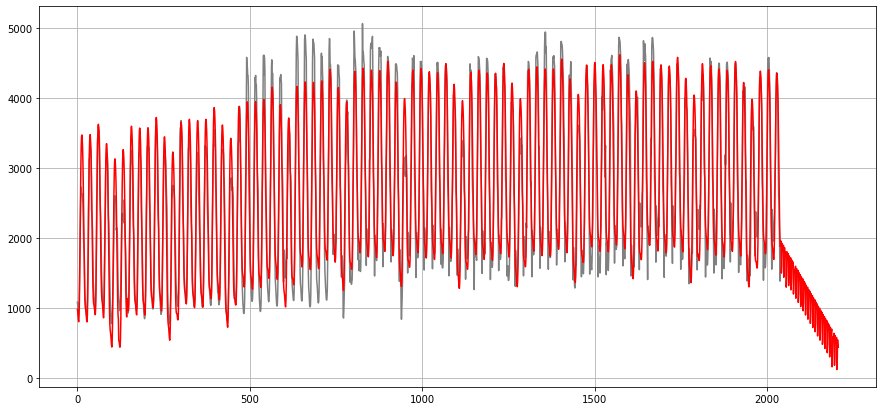

In [46]:
plt.figure(figsize=(15,7))
plt.plot(target_transform.inverse_transform(tr_d.y),color='gray')
plt.plot(target_transform.inverse_transform(pred),color='red')
plt.grid()
plt.show()